# Project 6. Rossman store sales forecasting
The goal of the **[competition](https://www.kaggle.com/competitions/rossmann-store-sales/overview)** is to forecast the store sales 6 weeks into the future - a very concrete objective - whilst essentially a regression tasks, due to the length of the prediction time target, it will definitely require a more careful approach, accounting for time-related transformations / characteristics of the data such as trends, seasonality and other factors, which might or might not be present in the data, influencing the historical, datetimed datapoints.

The specified measurement target of choice is the **Root Mean Square Percentage Error (RMSPE)**

Non-obvious columns/factors:
* Customers - the number of customers on a given day
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince(Month/Year) - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

The supplied data is split across multiple files for train data, test data (which can only be evaluated by submitting the prediction on it to the competition site) and data about stores, unrelated to time points.

For the purpose of a separate testing set, we will reserve a portion of the dataset ourselves to test the resultant models finetuned on train and validation data splits.

## Code setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [27]:
df_path = '../datasets/rossmann/train.csv'
df = pd.read_csv(df_path, index_col=0)

store_path = '../datasets/rossmann/store.csv'
store_df = pd.read_csv(store_path)

C:\Users\User\AppData\Local\Temp\ipykernel_3136\2426903770.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_path, index_col=0)


### Reversing the ordering of the train dataset
with cells commented out for safe notebook runs

In [12]:
df['Date'].max()

'2015-07-31'

In [13]:
df['Date'].min()

'2013-01-01'

In [23]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [14]:
df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [20]:
df_sorted = df.sort_values(by=['Date', 'Store'], ascending=True).reset_index(drop=True)

In [21]:
df_sorted.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2,2013-01-01,0,0,0,0,a,1
1,2,2,2013-01-01,0,0,0,0,a,1
2,3,2,2013-01-01,0,0,0,0,a,1
3,4,2,2013-01-01,0,0,0,0,a,1
4,5,2,2013-01-01,0,0,0,0,a,1


In [24]:
# df_sorted.to_csv(df_path)

## EDA, inspecting the data

In [28]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2,2013-01-01,0,0,0,0,a,1
1,2,2,2013-01-01,0,0,0,0,a,1
2,3,2,2013-01-01,0,0,0,0,a,1
3,4,2,2013-01-01,0,0,0,0,a,1
4,5,2,2013-01-01,0,0,0,0,a,1


In [30]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [31]:
df.shape

(1017209, 9)

In [32]:
store_df.shape

(1115, 10)

In [33]:
df.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [34]:
df.nunique()

Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         5
SchoolHoliday        2
dtype: int64

In [35]:
df['StateHoliday'].unique()

array(['a', '0', 'b', 'c', 0], dtype=object)

#### 'Date' column to datetime format

In [37]:
df['Date'] = pd.to_datetime(df['Date'])

In [38]:
df.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

In [45]:
means_df = df.groupby(by=['Date'], as_index=False)[['Sales', 'Customers', 'Open', 'Promo']].mean()

In [46]:
means_df

,Date,Sales,Customers,Open,Promo
0,2013-01-01,87.284560,17.496409,0.015260,0.0
1,2013-01-02,6233.030493,748.049327,0.996413,0.0
2,2013-01-03,5693.112108,682.547085,0.994619,0.0
3,2013-01-04,5954.218834,701.468161,0.993722,0.0
4,2013-01-05,5337.751570,616.566816,0.992825,0.0
...,...,...,...,...,...
937,2015-07-27,9602.952466,870.369507,0.998206,1.0
938,2015-07-28,8174.953363,785.732735,0.998206,1.0
939,2015-07-29,7623.284305,743.070852,0.998206,1.0
940,2015-07-30,7891.348879,769.997309,0.998206,1.0


Text(0.5, 1.0, 'Average sales over time')

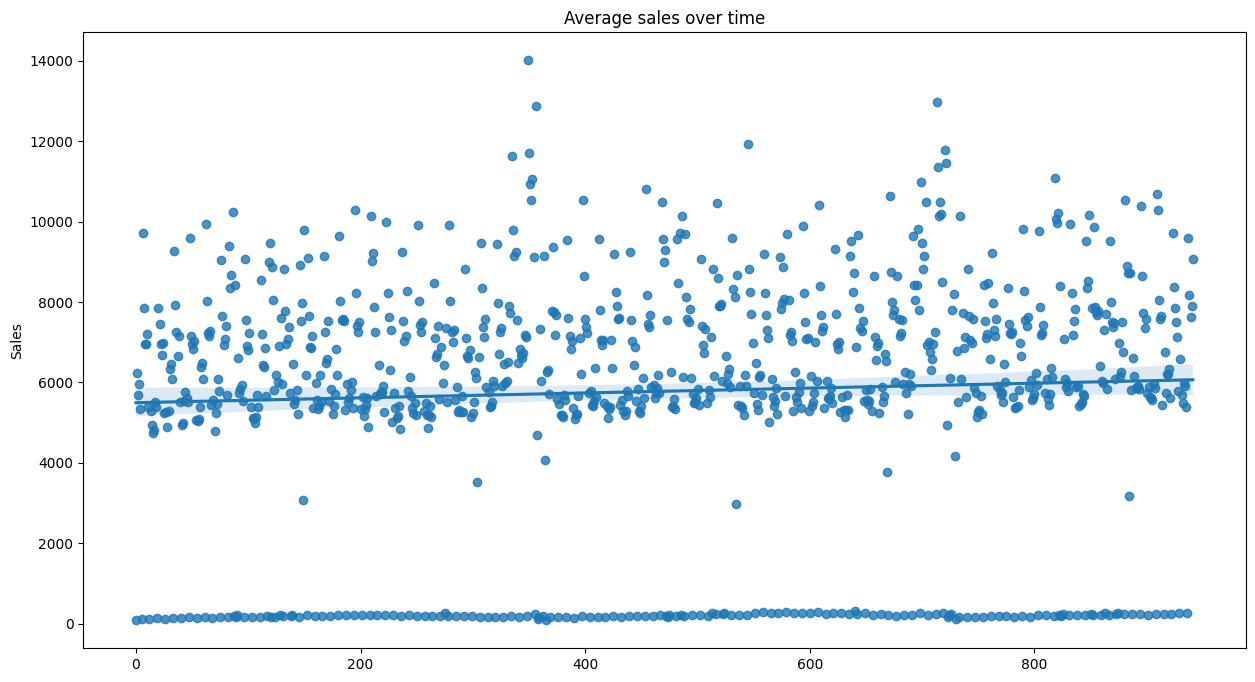

In [53]:
plt.figure(figsize=(15,8))
ax = sns.regplot(data=means_df, x=means_df.index, y='Sales')
ax.set_title("Average sales over time")

Text(0.5, 1.0, 'Average customers over time')

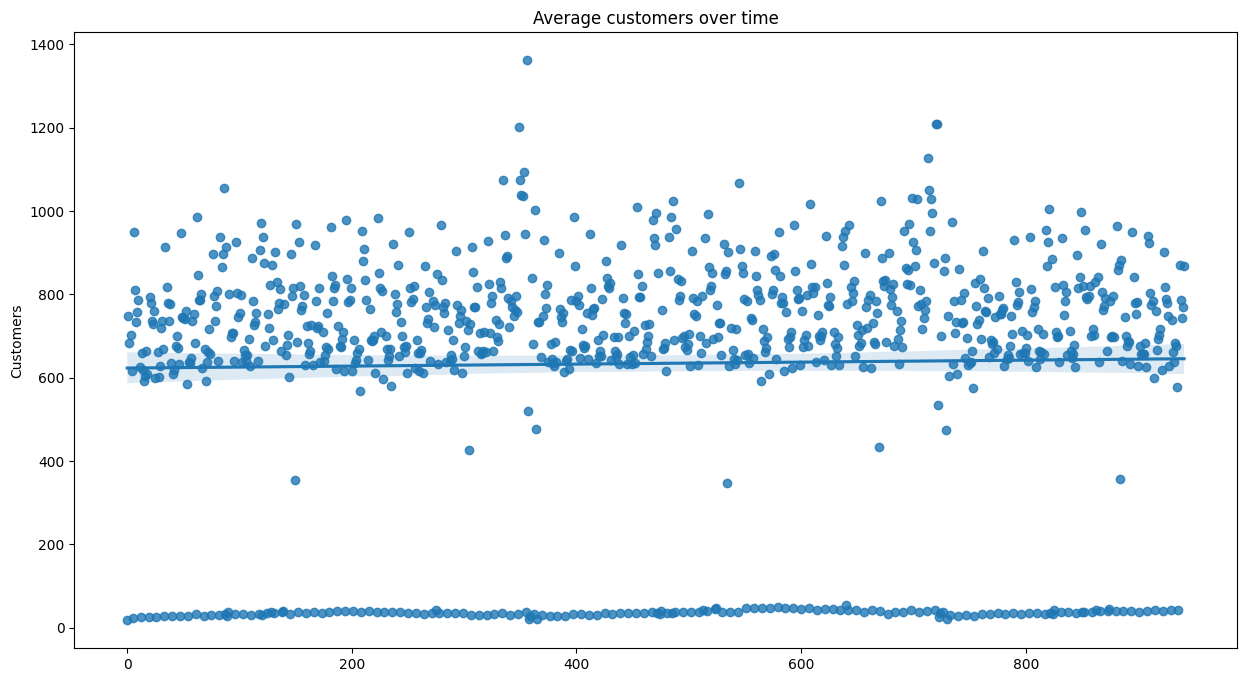

In [55]:
plt.figure(figsize=(15,8))
ax = sns.regplot(data=means_df, x=means_df.index, y='Customers')
ax.set_title("Average customers over time")

#### How about on singular stores?

In [62]:
store_33_df = df[df['Store'] == 33].groupby(by=['Date'], as_index=False)[['Sales', 'Customers', 'Open', 'Promo']].mean()
store_114_df = df[df['Store'] == 114].groupby(by=['Date'], as_index=False)[['Sales', 'Customers', 'Open', 'Promo']].mean()
store_256_df = df[df['Store'] == 256].groupby(by=['Date'], as_index=False)[['Sales', 'Customers', 'Open', 'Promo']].mean()

Text(0.5, 1.0, 'Average sales over time for random store (33 , 114 and 256)')

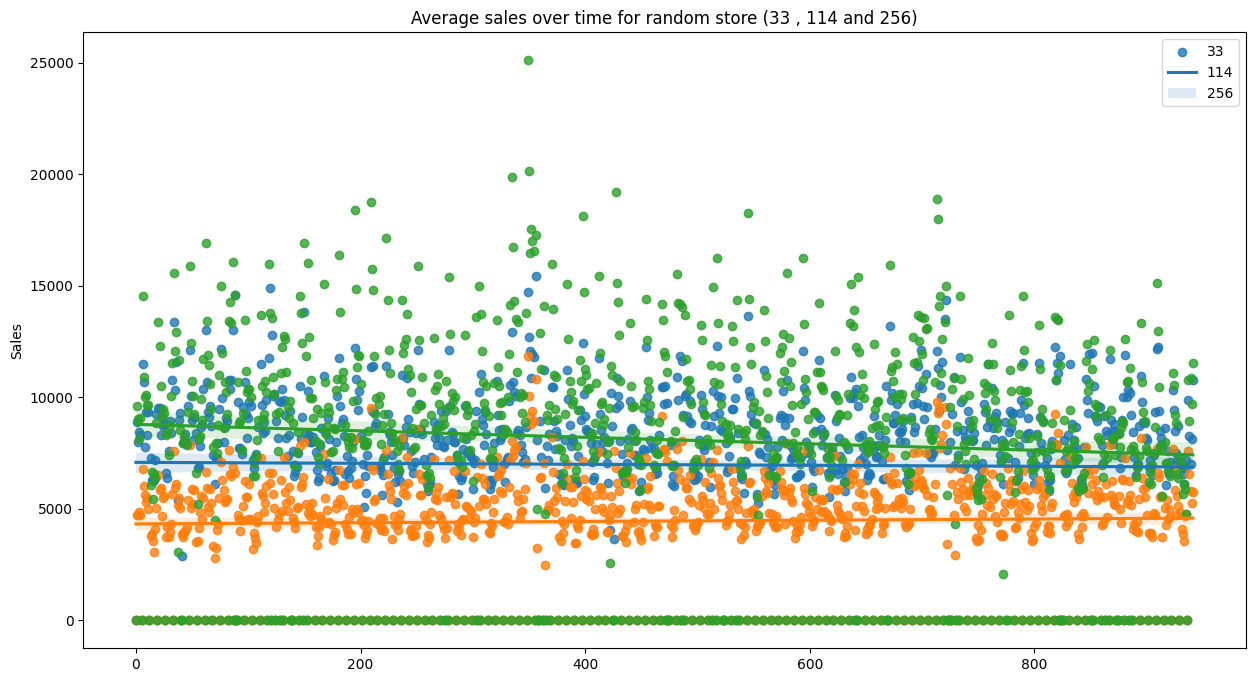

In [67]:
plt.figure(figsize=(15,8))
ax = sns.regplot(data=store_33_df, x=store_33_df.index, y='Sales')
ax = sns.regplot(data=store_114_df, x=store_33_df.index, y='Sales')
ax = sns.regplot(data=store_256_df, x=store_33_df.index, y='Sales')
plt.legend(['33', '114', '256'])
ax.set_title("Average sales over time for random store (33 , 114 and 256)")

Okay, the days with 0 sales (probably holidays or weekends) are really throwing the trends off, let's try to exclude them for a quick look

Text(0.5, 1.0, 'Store 33 no 0 sales')

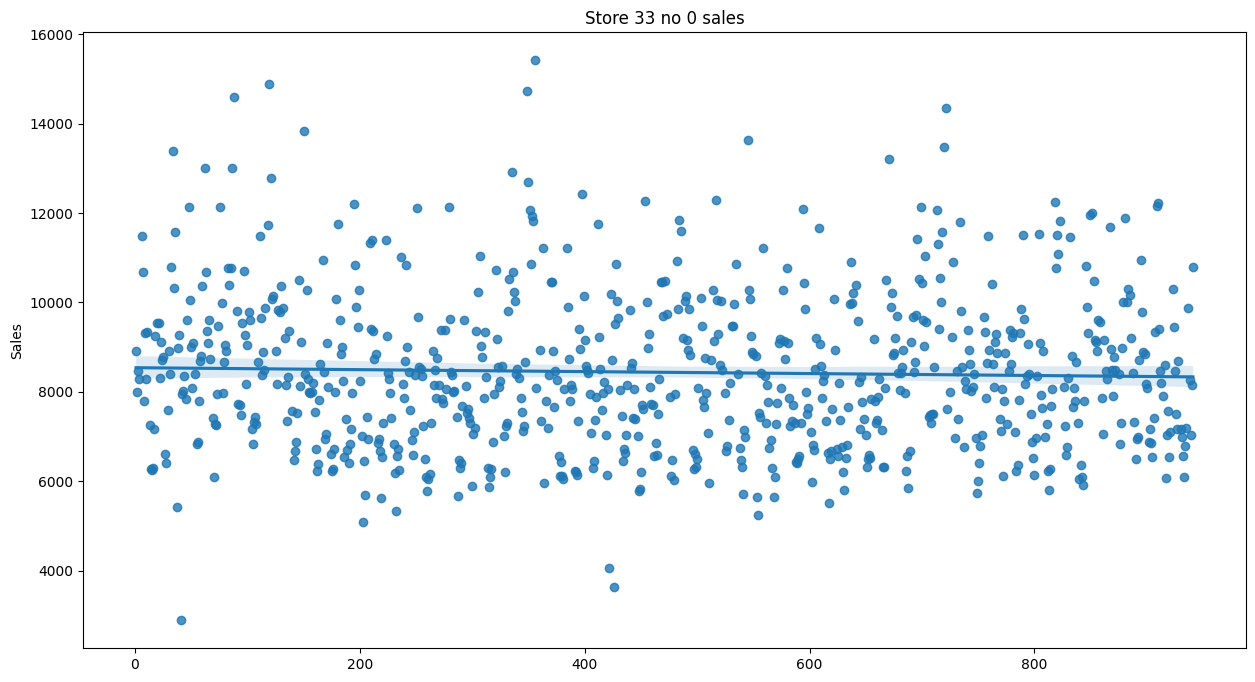

In [64]:
no_zero_33 = store_33_df[store_33_df['Sales'] > 0]
plt.figure(figsize=(15,8))
ax = sns.regplot(data=no_zero_33, x=no_zero_33.index, y='Sales')
ax.set_title("Store 33 no 0 sales")